# Ανάλυση και Επεξεργασία Γεωχωρικών Δεδομένων

## *Άσκηση 4: Ταξινόμηση Βίντεο με Αρχιτεκτονικές RNN & Transformers* 

- Ονομ/νυμο: Χρήστος Νίκου
- AM: 03400146
- Ιδιότητα: Μεταπτυχιακός φοιτητής Επιστήμης Δεδομένων και Μηχανικής Μάθησης (ΕΔΕΜΜ)
- Ηλεκτρονική Διεύθυνση: christosnikou@mail.ntua.gr / chrisnick92@gmail.com


# Table of Contents
- [1. Introduction](#intro)
    - [1.1 Short description](#intro11)
    - [1.2 Importing Libraries & Data Preperation](#intro12)
        - [1.2.1 Data Pipeline for NN architectures](#intro121)
        - [1.2.2 Generate DataLoader and Batching strategy](#intro122)
- [2. *CNN - RNN* Model - Implementation & Training](#2)
    - [2.1 The Architecture of the model](#2.1)
    - [2.2. Training and Results](#2.2)
- [3. Transformer Encoder - Implementation & Training](#3)
    - [3.1 The Architecture of the model](#3.1)
    - [3.2 Training and Results](#3.2)
- [4. Compairing the models](#4)

# 1. Introduction <a name="intro"></a>

## 1.1 Short description <a name="intro11"></a>

In this Fourth lab we turn our attention to the problem of
video classification. In particular, we are interested in comparing two different Neural Network architectures.
A Recurrent Neural Network (RNN) with an additional gating mechanism, the Gated recurrent
unit (GRU) and a Transformer consisting only of its Encoder part.

In detail, we train the two aforementioned models on a data-set consisting of 818 action videos,
collected from YouTube, separated in five different categories according to the depicted action. The
data-set we use in this Lab is a simplified version of the data-set <a href="https://www.crcv.ucf.edu/data/UCF101.php">lUCF101</a> consisting of 13320 videos
from 101 action categories. The action categories of the original data-set can be divided into five types:
1) Human-Object Interaction, 2) Body-Motion only, 3) Human-Human Interaction, 4) Playing Musical
Instruments and 5) Sports. The simplified version of the data-set contains videos from the following
five actions: 1) Cricket Shot, 2) Playing Cello, 3) Punch, 4) Shaving Beard and 5) Tennis Swing.

## 1.2 Importing Libraries & Data Preperation <a name="intro12"></a>

In [ ]:
!pip install pytorch-lightning av

%load_ext tensorboard

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 584 kB 29.8 MB/s 
     |████████████████████████████████| 28.2 MB 1.2 MB/s 
     |████████████████████████████████| 596 kB 23.6 MB/s 
     |████████████████████████████████| 409 kB 54.6 MB/s 
     |████████████████████████████████| 140 kB 60.7 MB/s 
     |████████████████████████████████| 1.1 MB 47.0 MB/s 
     |████████████████████████████████| 94 kB 2.2 MB/s 
     |████████████████████████████████| 144 kB 57.2 MB/s 
     |████████████████████████████████| 271 kB 14.2 MB/s 
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
# Downloading the Data - Videos

!wget -q https://git.io/JGc31 -O ucf101_top5.tar.gz
!mkdir data
!tar xf ucf101_top5.tar.gz --directory data

!gdown --fuzzy https://drive.google.com/file/d/1wJ_WN1khOrAyWOueYjT-WKsvi70F3gm_/view
!mkdir data
!unzip precomputed_features.zip
!unzip precomputed_features/precomp.zip -d data/

Downloading...
From: https://drive.google.com/uc?id=1wJ_WN1khOrAyWOueYjT-WKsvi70F3gm_
To: /content/precomputed_features.zip
100% 305M/305M [00:02<00:00, 103MB/s]
mkdir: cannot create directory ‘data’: File exists
Archive:  precomputed_features.zip
   creating: precomputed_features/
  inflating: precomputed_features/README.md  
  inflating: precomputed_features/precomp.zip  
Archive:  precomputed_features/precomp.zip
   creating: data/precomp/
  inflating: data/precomp/test_v_CricketShot_g01_c03.avi.tmp  
  inflating: data/precomp/train_v_ShavingBeard_g10_c05.avi.tmp  
  inflating: data/precomp/train_v_ShavingBeard_g22_c03.avi.tmp  
  inflating: data/precomp/train_v_TennisSwing_g09_c02.avi.tmp  
  inflating: data/precomp/test_v_PlayingCello_g07_c04.avi_91.tmp  
  inflating: data/precomp/train_v_ShavingBeard_g23_c02.avi.tmp  
  inflating: data/precomp/test_v_Punch_g06_c04.avi.tmp  
  inflating: data/precomp/train_v_CricketShot_g09_c04.avi.tmp  
  inflating: data/precomp/train_v_Punch_g14

In [ ]:
# Importing the libraries for this Notebook

from torchvision.models.feature_extraction import create_feature_extractor
from torchvision.transforms import ConvertImageDtype, Resize, Normalize
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader
from torchvision.models import resnet18
from torchvision.io import read_video
from typing import Callable, List
import torch.nn.functional as F
import pytorch_lightning as pl
import torch.nn as nn
import pandas as pd
import numpy as np
import torch
import pickle
import os

### 1.2.1 Data Pipeline for NN architectures <a name="intro121"></a>

In [ ]:
# Define data root directory
DATA_ROOT = "data/"

# Define a Video-transform type
VTransform = Callable[[torch.Tensor], torch.Tensor]

class UCF101(Dataset):
    def __init__(self, data_root, mode="train", video_transforms: List[VTransform]=[], use_precomputed=True):
        '''
        στα transforms prepei na κανουμε float32 των τανυστη στο μεγελθος που θελουμε, κανουμε ενα stadard resize, 
        kai βαζουμε τα χαρακτηριστικα normlization του συγκεκριμενου μοντελου- για το imagenet καθως ειναι rgb
        Return a UCF101 Dataset instance
        '''
        super().__init__()
        assert mode in ["train", "test"]
        
        self.root = data_root
        self.mode = mode
        self.v_transforms = video_transforms
        
        # Build database of samples
        self._build_db()
        
        # Features precomute functionality
        self.pre = use_precomputed
        self.pre_root = os.path.join(self.root, "precomp")
        if self.pre and not os.path.exists(self.pre_root):
            os.makedirs(self.pre_root)
        
    def _build_db(self):
        '''
        Parse train/test csv containing paths to videos and corresponding labels.
        Also, assign a unique index to each category
        '''
        csv_file = os.path.join(self.root, self.mode + ".csv")
        self.db: np.ndarray = pd.read_csv(csv_file, header=0).values
        
        unique_categories = np.sort(np.unique(self.db.T[1]))
        self.categories = {c_name: c_idx for c_idx, c_name in enumerate(unique_categories)}
        
    def compute_sample(self, video_name, category):
        '''
        For a specific video, read data into memory, permute data to NumFrames x Channels x Height x Width format.
        Also, transform data according to list of transforms
        '''
        
        # Load video
        V, *_ = read_video(os.path.join(self.root, self.mode, video_name))
        # Permute data to NxCxHxW from NxHxWxC
        V = V.permute(0,3,1,2) # τα συνελλικτικα δικτυα πρεπει πρωτα να μπει ο αριθμος των frames - δεν θελουμε reshaπε γιατι θα αλλαξει η σειρα των δικτων
        
        for T in self.v_transforms: # εδω εφαρμοζουμε τους μετασχηματισμους με τη σειρα
            V = T(V)
        
        return V, self.categories[category]
        
    def __getitem__(self, index):
        '''
        Retrieve a specific sample from the dataset
        '''
        video_name, category = self.db[index]
        
        hval = "_".join([
            self.mode,
            video_name
        ])
        
        if os.path.exists(os.path.join(self.pre_root, f"{hval}.tmp")):
            with open(os.path.join(self.pre_root, f"{hval}.tmp"), "rb") as f:
                sample =  pickle.load(f)
        else:
            sample = self.compute_sample(video_name, category)
            # Save tmp
            with open(os.path.join(self.pre_root, f"{hval}.tmp"), "wb") as f:
                pickle.dump(sample, f) # στην πρωτη εποχη υπολογιζονται ολα τα transforms και αποθηκευονται για να μην το κανουμε καθε φορα. γιατι παιρνει ωρα
            
        return sample
            
    def __len__(self):
        '''
        Returns the number of samples in the dataset
        '''
        return self.db.shape[0]

    
def compute_features() -> VTransform:
    '''
    Returns a VTransform object that uses a pretrained CNN to extract features
    '''
    # Instantiate a CNN for feature extraction
    #εδω παιρνουμε το δικτυο, αλλα δεν πρεπει να το βαλουμε μεσα στην applly γιατι θα το αρχικοποιουμε ξανα και ξανα
    encoder = resnet18(pretrained=True, progress=False)
    # model = nn.Sequential(*list(encoder.children())[:-1], nn.Flatten())
    model = create_feature_extractor(encoder, ["avgpool"]) # αναλαμβάνει να κοψει το δικτυο στην στρωση που θα του πουμε
    model.eval() # δεν θα το εκπαιδευσουμε γι αυτο γυρναμε σε validation mode
    
    def apply(v: torch.Tensor) -> torch.Tensor:    
        # return model(v)
        with torch.no_grad(): # δεν θελουμε να κραταει πληροφοριες - kanoyme inference σε ενα batch το οποιο εχει μεγεθος οσο τα frames
            feats = torch.flatten(model(v)["avgpool"], 1) # τρωμε το 1*1 χωρικες διαστασεις για να κρατησουμε μονο τα features- pairnei tensor γυρναει tensor
        return feats
    
    return apply

### 1.2.2 Generate DataLoaders and batching strategy <a name="intro122"></a>

In [ ]:
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader

batch_size = 16 # Hyperparameter for batch size

# Define train/val datasets
train_dset = UCF101(DATA_ROOT, "train", video_transforms=[
        ConvertImageDtype(torch.float32),
        Resize((224, 224)),
        Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]),
        compute_features()
    ])

val_dset = UCF101(DATA_ROOT, "test", video_transforms=[
        ConvertImageDtype(torch.float32),
        Resize((224, 224)),
        Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]),
        compute_features()
    ])


def pad_sequences_collate_fn(samples: List[tuple]) -> tuple:
    '''
    Zero-pad (in front) each sample to enable batching. The longest sequence defines the sequence length for the batch
    παιρνει λιστα απο samples - θα κανουμε αυτο με τα μηδενικα στηνα ρχη για να εχουν ολα το ιδιο length
    '''
    
    labels = torch.stack([torch.tensor(v[1]) for v in samples]) 
    data = pad_sequence([v[0] for v in samples]) 
    
    return data, labels
 
train_dloader = DataLoader(train_dset, batch_size=batch_size,
                           collate_fn=pad_sequences_collate_fn, shuffle=True, num_workers=0)
val_dloader = DataLoader(val_dset, batch_size=batch_size,
                         collate_fn=pad_sequences_collate_fn, shuffle=False, num_workers=0)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


In [ ]:
train = pd.read_csv(os.path.join(DATA_ROOT, "train.csv"))
print(f"{10*' '}DataSet Summary{10*' '}")
print(f"- There are {len(train['tag'].unique())} classes in total. These are\n")
for x in train['tag'].unique():
  print(x)
print(f"\n- The train set consists of {len(train_dloader.dataset)} samples.")
print(f"- The test set consists of {len(val_dloader.dataset)} samples.")

          DataSet Summary          
- There are 5 classes in total. These are

CricketShot
PlayingCello
Punch
ShavingBeard
TennisSwing

- The train set consists of 594 samples.
- The test set consists of 224 samples.


# 2. *CNN - RNN* Model - Implementation & Training <a name="2"></a>

# 2.1. The Architecture of the model <a name="2.1"></a>

In [ ]:
from torchmetrics import Accuracy, ConfusionMatrix, F1Score, Recall, Precision

class Seq2Vec(pl.LightningModule):
    def __init__(self, features_in, num_classes, learning_rate=1e-3):
        '''
        Returns a Seq2Vec RNN model
        '''
        super().__init__()
        # προβλημα many to one γι αυτο θελουμε μονο εναν encoder - δεν θελουμε 
        self.rnn_encoder = nn.GRU(
            input_size=features_in, # 512 ειναι τα χαρακτηριστικα
            hidden_size=32, # dimensionality hidden state
            num_layers=2, # βαζουμε δυο layers με gru
            batch_first=False, # το εχουν ολα τα rnn, seq-batch-prepie na προσεξουμε την pad_sequence εδω με ποια σειρα μπαινουν 
            dropout=0.3)
        
        self.classifier = nn.Sequential(
            nn.Linear(32, 16), # εδω ερχεται το 32 από τον encoder και πρεπει να το ταξινομησουμε
            nn.ReLU(),
            nn.Linear(16, num_classes)
        )
        
        self.lr = learning_rate
        self.val_accuracy = Accuracy() 
        self.val_confusion_matrix = ConfusionMatrix(num_classes)      
        self.save_hyperparameters()
        
    def forward(self, x):
        '''
        Forward-pass
        οταν τρεχουμε τα rnν γυρναει δυο πραγματα - το λεει στα docs - hout einai της τελευταιας στρωσεις - 
        '''
        rnn_out, h_n = self.rnn_encoder(x)
        #  rnn_out: L, B, 32
        return self.classifier(rnn_out[-1]) # το -1 ειναι το τελευταιο timestep sto στο τελευταιο κρyμμενο layer 

    def training_step(self, batch, batch_idx):
        '''
        Training logic
        '''
        X, y = batch

        logits = self(X)

        loss = F.nll_loss(torch.log_softmax(logits, dim=-1), y)
        self.log("loss/train", loss, on_epoch=True, on_step=False, batch_size=X.size()[1])

        return loss
    
    def validation_step(self, batch, batch_idx):
        '''
        Validation logic
        '''
        X, y = batch

        logits = self(X)

        loss = F.nll_loss(torch.log_softmax(logits, dim=-1), y)
        self.log("loss/val", loss, on_epoch=True, on_step=False, batch_size=X.size()[1])

        self.val_accuracy(logits, y)
        self.log("accuracy/val", self.val_accuracy, on_epoch=True, on_step=False, batch_size=X.size()[1])
        self.val_confusion_matrix(logits, y)
      
    
    def configure_optimizers(self):
        '''
        Setup Adam optimizer
        '''
        return torch.optim.Adam(self.parameters(), lr=self.lr)

## 2.2. Training and Results <a name="2.2"></a>

In [ ]:
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint

callbacks = [
    EarlyStopping(monitor="accuracy/val", mode="max", patience=50),
    ModelCheckpoint(monitor="accuracy/val", mode="max", save_last=True)
]

model = Seq2Vec(512, len(train_dset.categories), learning_rate=1e-4)
trainer = pl.Trainer(
    accelerator="gpu", 
    devices=1,
    min_epochs=250, # to gru θελει τουλαχιστον 200 εποχες - transoformer 10-20epoxew
    max_epochs=300,
    callbacks=callbacks,
    default_root_dir="seq2vec_gru"
)

trainer.fit(model, train_dataloaders=train_dloader, val_dataloaders=val_dloader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: seq2vec_gru/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type            | Params
---------------------------------------------------------
0 | rnn_encoder          | GRU             | 58.8 K
1 | classifier           | Sequential      | 613   
2 | val_accuracy         | Accuracy        | 0     
3 | val_confusion_matrix | ConfusionMatrix | 0     
---------------------------------------------------------
59.4 K    Trainable params
0         Non-trainable params
59.4 K    Total params
0.237     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:1931: PossibleUserWarning: The number of training batches (38) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  category=PossibleUserWarning,


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

def test_loop(model, test_dloader, device = 'cpu'):
  predictions_list = np.array([])
  targets_list = np.array([])
  model.eval()

  for val_sample in test_dloader:
    X = val_sample[0].to(device)
    y = val_sample[1].cpu().numpy()
    targets_list = np.concatenate((targets_list, y))

    with torch.no_grad():
      preds = model(X)
      predictions_list = np.concatenate((predictions_list,
                                         torch.argmax(preds, dim=-1).cpu().numpy()))
  
  return predictions_list, targets_list

In [ ]:
preds, targets = test_loop(model, val_dloader)
print(classification_report(targets, preds))

              precision    recall  f1-score   support

         0.0       0.82      0.73      0.77        49
         1.0       1.00      0.86      0.93        44
         2.0       0.77      0.95      0.85        39
         3.0       0.98      1.00      0.99        43
         4.0       0.86      0.88      0.87        49

    accuracy                           0.88       224
   macro avg       0.89      0.88      0.88       224
weighted avg       0.89      0.88      0.88       224



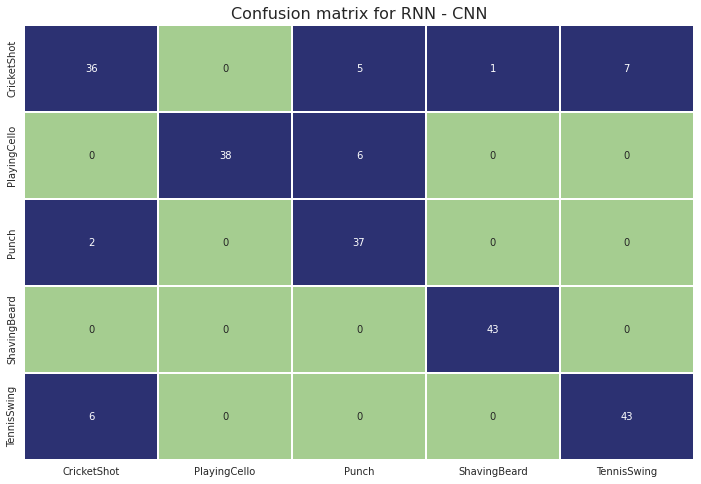

In [ ]:
categories = list(train_dset.categories.keys())
cm = confusion_matrix(targets, preds)

import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("dark")
sns.color_palette("crest", as_cmap=True)
fig, ax = plt.subplots(figsize=(12,8))

sns.heatmap(cm, linewidths=.5, ax=ax, vmin=0.8, vmax=1,
            xticklabels=categories, yticklabels=categories, cmap = "crest",
            annot = True, cbar = False)
ax.set_title('Confusion matrix for RNN - CNN', fontsize=16)
plt.savefig("rnn.png")
plt.show()

# 3. Transformer Encoder - Implementation & Training <a name="3"></a>

## 3.1 The Architecture of the Model <a name="3.1"></a>


In [ ]:
import math
import pickle
from torch import Tensor
from typing import Tuple
from torch.optim import Adam
from typing import Callable, List
from torch.nn import TransformerEncoder, TransformerEncoderLayer

# Positional Enconding
class PositionalEncoding(nn.Module):

  def __init__(self, d_model: int, dropout: float = 0.1,
               max_len: int = 5000):
    super().__init__()
    self.dropout = nn.Dropout(p = dropout)

    position = torch.arange(max_len).unsqueeze(1)
    div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0)/d_model))
    pe = torch.zeros(max_len, 1, d_model)
    pe[:, 0, 0::2] = torch.sin(position*div_term)
    pe[:,0, 1::2] = torch.cos(position*div_term)
    self.register_buffer('pe', pe)

  def forward(self, x: Tensor) -> Tensor:
    x = x + self.pe[:x.size(0)]
    return self.dropout(x)

# The main architecture - Encoder part

class Encoder(nn.Module):

  def __init__(self, d_model: int, num_classes: int, nhead: int,
               nlayers: int, classifier_size:int = 128, dropout: float = 0.2):
    super().__init__()
    self.model_type = 'Encoder'
    self.pos_encoder = PositionalEncoding(d_model, dropout)
    encoder_layer = nn.TransformerEncoderLayer(d_model, nhead, dim_feedforward= 1024,
                                                    dropout = dropout, layer_norm_eps=1e-03)
    self.encoder = nn.TransformerEncoder(encoder_layer, nlayers)

    self.classifier = nn.Sequential(
        nn.Linear(d_model, classifier_size),
        nn.ReLU(),
        nn.Linear(classifier_size, num_classes)
    )


  def forward(self, x: Tensor, src_key_padding_mask = None) -> Tensor:
    x = self.pos_encoder(x)
    x = self.encoder(x, src_key_padding_mask = src_key_padding_mask)
    x = x.amax(dim = 0)
    output =self.classifier(x)
    return output

## 3.2 Training and Results <a name="3.2"></a>

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = Encoder(d_model = 512, num_classes = len(categories), nhead =8, 
                nlayers = 6, dropout = 0.1).to(device)

epochs = 20
lr = 1e-5
batch_size = 24

loss_fn = nn.CrossEntropyLoss().to(device)


def training_loop(model, train_loader, val_loader, epochs = epochs, lr = lr, batch_size = batch_size,
                    loss_fn = loss_fn, val = True, graph = True, pr = True, encoder = True):
  optim = Adam(model.parameters(), lr = lr)

  # Initialize lists to create a graph
  train_loss_list = []
  val_loss_list = []
  # Store the number batches of training and val sets
  num_train_batches = len(train_loader)
  num_val_batches = len(val_loader)

  for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    val_loss = 0.0
    if graph:
      print(f"\n{5*'-'}> Epoch {epoch+1} <{5*'-'}\n")
    for batch_sample in train_loader:
      X = batch_sample[0].to(device)
      key_padding_mask = (((X!=0).transpose(0,1).sum(dim=2)) == 0).to(device)
      y = batch_sample[1].to(device)

      preds = model(X,key_padding_mask) if encoder else model(X)
      loss = loss_fn(preds, y)
      train_loss += loss.item()
      # Backpropagation
      optim.zero_grad()
      loss.backward()
      optim.step()
    model.eval()
    with torch.no_grad():
      for val_sample in val_loader:
        X = val_sample[0].to(device)
        y = val_sample[1].to(device)
        preds = model(X)
        val_loss += loss_fn(preds, y).item()
      
    train_loss /= num_train_batches
    val_loss /= num_val_batches
    train_loss_list.append(train_loss)
    val_loss_list.append(val_loss)
    if pr:
      print(f"Epoch {epoch+1}/{epochs}{5*' '}Train loss: {train_loss:.5f}{5*' '}Val loss:{val_loss:.5f}")
  
  if graph:
    fig, ax = plt.subplots(figsize = (8,8))
    sns.set_style("dark")
    ax.plot(range(1,epochs+1), train_loss_list, label = 'Train Loss')
    ax.plot(range(1,epochs+1), val_loss_list, label = 'Val Loss')
    ax.set_title("Train - Val Loss")
    ax.set_xlabel("Loss")
    ax.set_ylabel("Epochs")
    plt.legend()
    plt.show()


-----> Epoch 1 <-----

Epoch 1/20     Train loss: 1.32696     Val loss:1.19543

-----> Epoch 2 <-----

Epoch 2/20     Train loss: 0.80208     Val loss:0.87394

-----> Epoch 3 <-----

Epoch 3/20     Train loss: 0.48470     Val loss:0.68989

-----> Epoch 4 <-----

Epoch 4/20     Train loss: 0.29700     Val loss:0.53606

-----> Epoch 5 <-----

Epoch 5/20     Train loss: 0.18983     Val loss:0.45682

-----> Epoch 6 <-----

Epoch 6/20     Train loss: 0.12859     Val loss:0.38440

-----> Epoch 7 <-----

Epoch 7/20     Train loss: 0.09723     Val loss:0.37144

-----> Epoch 8 <-----

Epoch 8/20     Train loss: 0.07546     Val loss:0.33757

-----> Epoch 9 <-----

Epoch 9/20     Train loss: 0.06025     Val loss:0.32167

-----> Epoch 10 <-----

Epoch 10/20     Train loss: 0.04952     Val loss:0.30006

-----> Epoch 11 <-----

Epoch 11/20     Train loss: 0.04218     Val loss:0.27317

-----> Epoch 12 <-----

Epoch 12/20     Train loss: 0.03630     Val loss:0.26192

-----> Epoch 13 <-----

Epoch 13/

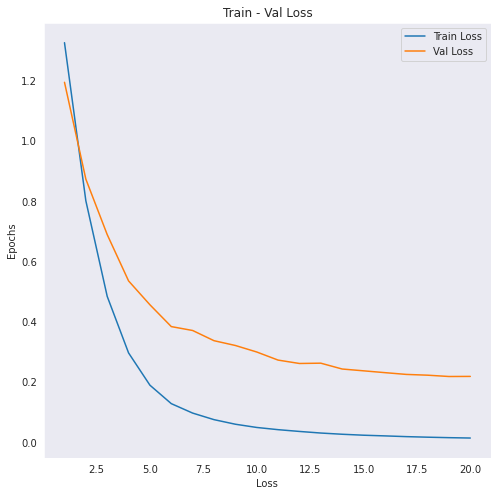

In [ ]:
training_loop(model, train_dloader, val_dloader, epochs = epochs,
              lr = lr, batch_size = batch_size, loss_fn = loss_fn)

In [ ]:
preds, targets = test_loop(model, val_dloader, device = device)

print(classification_report(targets, preds))

              precision    recall  f1-score   support

         0.0       0.89      0.96      0.92        49
         1.0       1.00      0.98      0.99        44
         2.0       0.97      0.95      0.96        39
         3.0       0.93      1.00      0.97        43
         4.0       0.95      0.86      0.90        49

    accuracy                           0.95       224
   macro avg       0.95      0.95      0.95       224
weighted avg       0.95      0.95      0.95       224



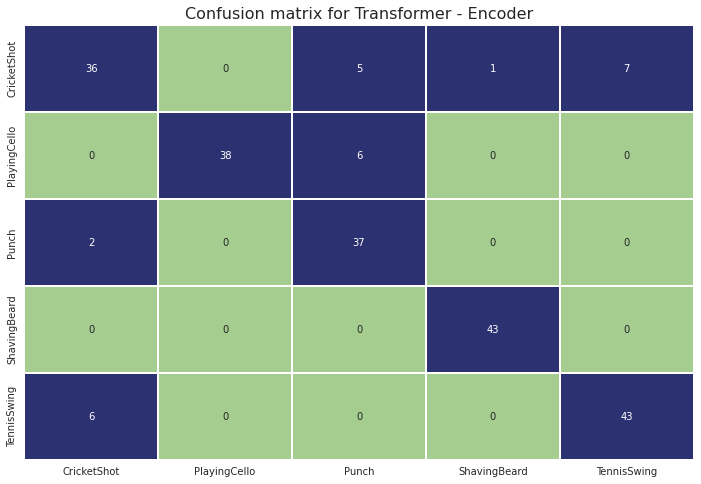

In [ ]:
sns.set_style("dark")
sns.color_palette("crest", as_cmap=True)
fig, ax = plt.subplots(figsize=(12,8))

sns.heatmap(cm, linewidths=.5, ax=ax, vmin=0.8, vmax=1,
            xticklabels=categories, yticklabels=categories, cmap = "crest",
            annot = True, cbar = False)
ax.set_title('Confusion matrix for Transformer - Encoder', fontsize=16)
plt.show()

#4. Comparing the models <a name="4"></a>

In [ ]:
import time
num_iters = 5
batch_size = 16
epochs1 = 200
epochs2 = 20
loss_fn = nn.CrossEntropyLoss().to(device)
lr1 = 1e-4
lr2 = 1e-5

for i in range(num_iters):
  print(f"{10*'-'}> Iter: {i+1} <{10*'-'}\n")
  rnn = Seq2Vec(512, len(train_dset.categories), learning_rate=1e-4).to(device)
  encoder = Encoder(d_model = 512, num_classes = len(categories), nhead =8, 
                nlayers = 6, dropout = 0.1).to(device)
  

  train_dloader = DataLoader(train_dset, batch_size=batch_size,
                            collate_fn=pad_sequences_collate_fn, shuffle=True, num_workers=0)
  val_dloader = DataLoader(val_dset, batch_size=batch_size,
                          collate_fn=pad_sequences_collate_fn, shuffle=False, num_workers=0)
  
  tic = time.time()
  training_loop(rnn, train_dloader, val_dloader, epochs = epochs1,
              lr = lr1, batch_size = batch_size, loss_fn = loss_fn, pr = False, graph = False,
              encoder = False)
  tac = time.time()
  
  preds, targets = test_loop(rnn, val_dloader, device = device)

  print(f"- Rnn results\n ")
  print(f"- Training time: Min: {((tac-tic)//60)} Sec: {((tac-tic) % 60):.4f}")
  print(classification_report(targets, preds))
  tic = time.time()
  training_loop(encoder, train_dloader, val_dloader, epochs = epochs2,
            lr = lr2, batch_size = batch_size, loss_fn = loss_fn,
            pr = False, graph = False)
  tac = time.time()
  
  print(f"\n Encoder results\n")
  print(f"- Training time: Min: {((tac-tic)//60)} Sec: {((tac-tic) % 60):.4f}")
  preds, targets = test_loop(encoder, val_dloader, device = device)
  print(classification_report(targets, preds))

----------> Iter: 1 <----------

- Rnn results
 
- Training time: Min: 4.0 Sec: 19.1787
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        49
         1.0       0.73      0.98      0.83        44
         2.0       0.86      0.92      0.89        39
         3.0       0.32      0.86      0.47        43
         4.0       0.44      0.08      0.14        49

    accuracy                           0.54       224
   macro avg       0.47      0.57      0.47       224
weighted avg       0.45      0.54      0.44       224



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



 Encoder results

- Training time: Min: 2.0 Sec: 17.6978
              precision    recall  f1-score   support

         0.0       0.98      0.88      0.92        49
         1.0       1.00      1.00      1.00        44
         2.0       0.97      0.97      0.97        39
         3.0       0.98      1.00      0.99        43
         4.0       0.91      0.98      0.94        49

    accuracy                           0.96       224
   macro avg       0.97      0.97      0.97       224
weighted avg       0.97      0.96      0.96       224

----------> Iter: 2 <----------

- Rnn results
 
- Training time: Min: 4.0 Sec: 15.3548
              precision    recall  f1-score   support

         0.0       0.35      0.94      0.51        49
         1.0       1.00      1.00      1.00        44
         2.0       1.00      0.92      0.96        39
         3.0       1.00      0.07      0.13        43
         4.0       0.62      0.10      0.18        49

    accuracy                           